# Creating the RS

Big issues: 
1. The LightFM scores did not relate to the scores in the table (issue is LightFM predicts similarity scores, not ratings as seen from Siraj lastfm RS)
2. LightFM produced embeddings (check if these are related to the fastai embeddings)
3. Perhaps using fastai collab learner with Google Colab, we can get actual embeddings
4. It's hard to tell which labels (left/right bill, left/right person) go with which embeddings

Fixes:
1. LightFM cannot handle features with -1 0 1 as the representation so we must use:
    * -1 -> 0
    * 1 -> 5 (for 5 stars)
    * 0 -> missing
2. Check documentation for LightFM
3. Implement fastai version

## Imports

In [169]:
import time
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

## MP Voting Data
Visualise?

In [283]:
# Lets say there are 10 different bills: 3 leftwing, 3 rightwing, 3 middleground and 1 other (e.g. anarchistic)
bill_list = ['left1','left2','left3','right1','right2','right3','mid1','mid2','mid3','other1']
num_bills = 11 # do not change!

# And 10 MPs in a random voting configuration
#MPs = ['l1','l2','l3','r1','r2','r3','m1','m2','m3','o1']
num_MPs = 1000
MPs = np.ones((num_MPs,1))

# And a voting schematic (mps v bills)
np.random.seed(0)

#fake vote set
numl = math.floor(num_MPs*0.3)
numr = math.floor(num_MPs*0.3)
numm = math.floor(num_MPs*0.3)
numo = num_MPs - numl - numr - numm
votesl = np.tile(np.array([1,1,1, 0,0,0, 0,0,0, 0,0]),numl) # left
votesr = np.tile(np.array([0,0,0, 1,1,1, 0,0,0, 0,0]),numr) # right
votesm = np.tile(np.array([0,0,0, 0,0,0, 1,1,1, 0,0]),numm) # middle
voteso = np.tile(np.array([0,0,0, 0,0,0, 0,0,0, 1,1]),numo) # other
votes = np.concatenate((votesl,votesr,votesm,voteso), axis=None)
votes=votes.reshape((num_MPs,11))
votes = votes.astype(float) # convert int32 to float for rescaling and NaN
#votes

In [284]:
# add randomness
vote_flip = np.random.binomial(n=1,p=0.05,size=(num_MPs,num_bills))
votes = (votes + vote_flip)%2
votes[:20]

array([[1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.

In [285]:
# adding nans fails with tsne visualisation -> use 1 0 -1 
vote_nans = np.random.binomial(n=1,p=0.05,size=(num_MPs,num_bills))
vote_nans = vote_nans.astype(float)
votes[vote_nans == 1] = float('NaN') #0
#votes = votes.astype('int32')
votes *= 5
votes[:20]

array([[ 5.,  5.,  5.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.],
       [ 5.,  5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.],
       [ 5.,  5.,  5.,  0., nan,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  5.,  5.,  0., nan,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  5., nan,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.],
       [ 5.,  5.,  5.,  0.,  0.,  0.,  0.,  0., nan,  0.,  0.],
       [ 5.,  5.,  5.,  0.,  5.,  0.,  5.,  0., nan,  0.,  0.],
       [ 5.,  5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  5., nan,  0.,  0., nan,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  5.,  5.,  0.,  5., nan,  0.,  0.,  0.,  0.,  5.],
       [ 5.,  5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  0., nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  5.,  5.,  0.,  0.,  0., nan,  0.,  0.,  0.,  0.],
       [ 5.,  5., nan,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.],
       [ 5.,  5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.],
       [ 5.,  5.,  5.,  0.,  0.,  0.,  0

## Clustering Visualisation

In [286]:
#convert nan to 0
x_subset = np.copy(votes)
x_subset[np.isnan(x_subset)] = 0
x_subset[:20]

array([[5., 5., 5., 0., 0., 0., 0., 0., 5., 0., 0.],
       [5., 5., 5., 0., 0., 0., 0., 0., 0., 5., 0.],
       [5., 5., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 5., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 5., 0., 0., 0., 0., 0., 0., 5., 0., 0.],
       [5., 5., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 5., 5., 0., 5., 0., 5., 0., 0., 0., 0.],
       [5., 5., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 5., 5., 0., 5., 0., 0., 0., 0., 0., 5.],
       [5., 5., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 5., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 5., 0., 0., 0., 0., 5., 0., 0., 0., 0.],
       [5., 5., 5., 0., 0., 0., 0., 0., 0., 0., 5.],
       [5., 5., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 5., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 5., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 5., 5., 0., 0., 0., 0., 0., 0., 0.

In [190]:
# Utility function to visualize the outputs of PCA and t-SNE

def tsne_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors])#.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [287]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

tsne = TSNE(random_state=RS).fit_transform(x_subset)

print(f't-SNE done! Time elapsed: {time.time()-time_start} seconds')

t-SNE done! Time elapsed: 8.292394161224365 seconds


In [288]:
# create y list of MP groups
y_list = ['0']*numl + ['1']*numr + ['2']*numm + ['3']*numo
y_list_int = list(map(int, y_list))
y_subset = np.array(y_list_int)
type(y_list_int)

list

(<Figure size 576x576 with 1 Axes>,
 [Text(-23.22723, -1.9692097, '0'),
  Text(7.2729163, -25.45921, '1'),
  Text(5.4156227, 26.848106, '2'),
  Text(15.4130745, 1.352847, '3')])

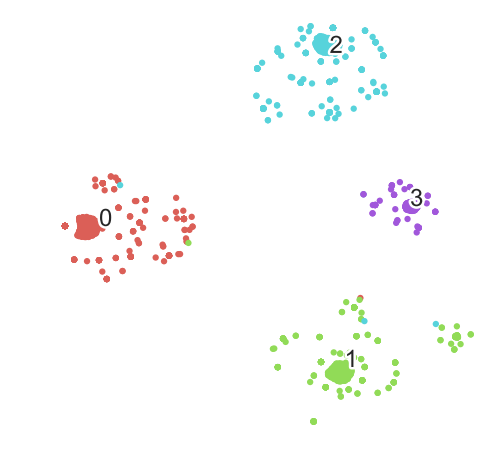

In [289]:
# Visualise labelled TSNE output
tsne_scatter(tsne,y_subset) 

## Data Preprocessing for Lightfm

Convert the file below where

users -> voters
restaurants -> bills

for voting (like star ratings for reviews)
1 -> 1
0 -> 0
-1 -> -1

In [242]:
# LIBRARIES
import os.path
import re
import sys
from scipy.sparse import coo_matrix

In [243]:
# for n,voter in enumerate(votes):
#     for vote in voter:
#         print(n,vote)

In [244]:
# Data to create our coo_matrix
data, row, col = [], [], []

# Restaurants and users
bills, voters = {}, {}

In [245]:
# cycle voter then nest bill
for voter, voters_votes in enumerate(votes):
    for bill_id, score in enumerate(voters_votes):
        data.append(score) # +1,0,-1 vote
        row.append(voter) # voter number number id
        col.append(bill_id) # bill number id

#print(data, row, col)
#print(len(data), len(row), len(col))

In [246]:
# Our matrix: ((visited, (user, restaurant)))
coo = coo_matrix((data,(row,col)))

# We return the matrix, the restaurant dict and the users
dictionary = {
    'matrix' : coo,
    # add bill and voter names/tags at a later date
    #'bills' : bills,
    #'votes' : voters
    }

## Fitting Lightfm

In [247]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k

data = dictionary

model = LightFM(loss='warp')
model.fit(data['matrix'], epochs=30, num_threads=2)

## Visualising 

Prediction of model compared to original

In [248]:
precision_at_k(model,data['matrix'],k=5).mean()

1.0

In [249]:
recall_at_k(model,data['matrix'],k=5).mean()

0.45454545454545436

In [256]:
scores = np.empty([num_MPs,num_bills])
for voter in np.arange(num_MPs):
    score = model.predict(voter,np.arange(num_bills))*1e3
    scores[voter] = score

In [257]:
for voter in np.arange(num_MPs):
    print(x_subset[voter], scores[voter])

[ 1  1  1 -1 -1 -1 -1 -1  1 -1 -1] [ 2.93286936 -0.48131275  3.02733947 -4.49151918  0.4386717  -2.10882723
 -3.52675701  5.49451774 -5.96178602 -1.23527867  2.29785871]
[ 1  1  1 -1 -1 -1 -1 -1 -1  1 -1] [ 1.75596424 -2.33748788 -4.16758284 -0.66655769  2.90151918  1.27706409
  5.13163768 -0.58168999  0.12030537  3.35188722 -0.62880584]
[ 1  1  1 -1  0 -1 -1 -1 -1 -1 -1] [ 0.62982074 -2.6318999   5.3463201   0.46766107 -0.12702256  0.34125362
 -3.77358613  1.09677354 -0.31427422 -2.71580927  0.26435521]
[ 1  1  1 -1  0 -1 -1 -1 -1 -1 -1] [-0.36309962  1.88448175 -0.57944743  2.3839823  -5.15830051  0.53906767
  0.16901936  0.25726616 -0.73299772 -0.54765015 -0.50757884]
[ 1  1  0 -1 -1 -1 -1 -1  1 -1 -1] [-0.64308266  0.71111287  1.36648188  3.29626887 -3.14959954  0.68157993
  1.14460581 -2.3974136   6.44302554 -3.71214119 -0.61407028]
[ 1  1  1 -1 -1 -1 -1 -1  0 -1 -1] [-0.99929224 -1.05856895 -4.51252516  1.3751752  -0.61986677  0.10204164
  3.0827499  -4.68749786  0.63861301  1.54

  5.50868781 -1.70305511 -0.16791746  1.28049916  2.96465261]
[-1 -1 -1  1  0  1 -1 -1 -1 -1 -1] [ 1.08840852  2.05940986 -0.79451513 -1.2160138   1.31931924  4.98751691
 -1.94917386  2.9133365   0.19961491 -0.58129564 -3.16317845]
[-1 -1 -1  1  1 -1 -1 -1 -1  0  0] [-0.80326654 -3.21152108  2.71453988  1.00012543 -1.09519484  1.12438155
 -0.62348705  3.37340566 -0.08582073 -3.26285232  2.00454099]
[-1 -1 -1  1  1  1 -1 -1 -1 -1 -1] [ 0.47555356  0.56841067 -1.29962922 -2.19847239  1.89351104  2.22197967
 -0.79509144  1.2714183  -1.57543097  0.48221668 -2.85307295]
[-1 -1 -1  1  1  1 -1 -1 -1 -1  1] [ 0.28244572  1.86014734 -2.19105463 -0.56838105 -0.44668731 -2.3636613
  2.61156494 -0.88841526  0.54623076  1.33682066  0.91488683]
[-1 -1 -1  1  1  1 -1 -1 -1 -1 -1] [-6.68446254 -0.96149935 -0.79865044  2.81964941  2.14937655 -1.39986421
  2.48100702 -2.37502996  3.63860629 -0.36085595 -1.76957971]
[-1  0 -1  1  1  1 -1 -1 -1 -1 -1] [ 0.23730543  1.43897068  0.51827705  0.59192081 -1.88

[-1 -1 -1 -1 -1 -1  1  1  1 -1 -1] [-0.64677687  6.27029268  3.4661144   1.93304941 -2.94355303  2.01144908
 -2.20967177  2.04947172  1.92246668  0.76271972 -5.55269513]
[-1 -1 -1 -1 -1 -1  0  1  1 -1 -1] [ 1.17753982  1.56737806  1.76109665 -0.7637883   0.90169912  4.91194567
 -5.58928959  0.87424979  0.1061834  -2.09854729 -3.89130949]
[-1 -1 -1  1 -1 -1  1  1  1 -1  1] [ 0.69212145  0.43787598  2.76062312  3.87596386 -4.84398147 -1.45415636
  0.07261999  0.11766318 -0.12052497  0.41252596  1.27270981]
[-1 -1 -1 -1 -1 -1  1 -1  1 -1 -1] [ 4.76444839  2.01317575  4.32646135 -2.44920421 -3.24591761 -0.99656766
 -4.33523813  2.52186321 -1.69455924 -3.09922523  1.11449696]
[-1 -1 -1 -1 -1 -1  1  1  1 -1 -1] [ 0.26216623 -4.51435801 -1.44755282 -2.52066692  3.7691046  -3.34598892
  2.81032175  0.64213946 -1.80740864  0.64314908  5.02255326]
[-1 -1 -1 -1 -1 -1  1  1  1  1 -1] [ 2.39610183  0.65852702  3.93735711 -0.85214502  0.69079077  1.88659446
 -2.34277267  3.48387938  1.77121791 -2.35

In [258]:
# voter weights
voter_weights = model.get_user_representations()
voter_components = np.transpose(voter_weights[1]) # parse region 1
voter_components[0] # component 0

array([-0.03917654,  0.03201505, -0.0136244 ,  0.01958284, -0.02039818,
        0.04291764, -0.0162845 ,  0.02562449,  0.01646485, -0.02068631,
        0.01836105,  0.02934432, -0.03067586, -0.03927039, -0.03126618,
       -0.00177295, -0.02820805, -0.04364952, -0.02574594, -0.04117289,
        0.03539246, -0.02911909,  0.02519351,  0.04006749,  0.03637486,
       -0.03855518, -0.03024406,  0.02751393,  0.04626629, -0.03429913,
       -0.03413119,  0.02761505, -0.01402067, -0.02848999,  0.00149513,
        0.01227108,  0.03857132,  0.04284427, -0.0082198 ,  0.04114727,
       -0.03679172, -0.02569564, -0.00806121,  0.03378083,  0.02503341,
       -0.00513065,  0.00989285,  0.01222775,  0.00765618, -0.02865032,
       -0.00552443, -0.00919721, -0.01116655, -0.00439152, -0.01857842,
       -0.03331774, -0.044177  , -0.02740401, -0.02716826, -0.00250658,
        0.0215539 , -0.00056008, -0.04664367, -0.00115528,  0.01480245,
        0.04849866,  0.00389343,  0.04384026, -0.00146186,  0.00

In [259]:
# bill weights
bill_weights = model.get_item_representations()
bill_components = np.transpose(bill_weights[1])
bill_components[2]

array([-0.02676265, -0.03389367, -0.04734398,  0.04434715,  0.00355756,
        0.02220782,  0.03019108, -0.03471862,  0.02776837,  0.00681816,
        0.04452736], dtype=float32)

In [260]:
# votes
data['matrix'].data

array([ 1.,  1.,  1., ..., -1.,  1.,  1.], dtype=float32)

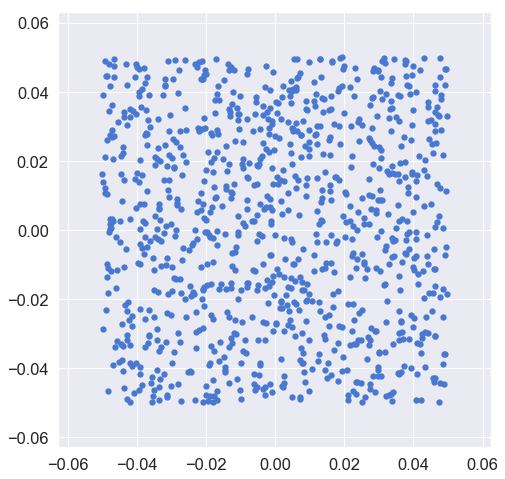

In [262]:
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(voter_components[0], voter_components[1], lw=0, s=40)

array([ 1.,  1.,  1., ..., -1., -1.,  0.], dtype=float32)